In [81]:
#DO NOT EDIT
import os, sys 
import cv2
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
import math
import numpy as np

from raytracer_utils import *
from debug_utils import * 

%load_ext autoreload
%autoreload 2

def show_image(file, height:float=10, width:float=10, title=None):
    if isinstance(file,str):
        if not os.path.isfile(file):
            raise IOError(f"{file} does not exist! Make sure you saved your images correctly.")
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img=file
    plt.gcf().set_size_inches(width,height)
    plt.gca().grid(None)
    plt.gca().axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(img)
    plt.show()
    
def plot_images(images, height:float=10, width:float=10):
    fig,axes=plt.subplots(1,len(images))
    fig.set_size_inches(width,height)
    for i,(img,label) in enumerate(images):
        ax=axes[i]
        ax.grid(None)
        ax.axis("off")
        ax.set_title(label)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

def print_emph(txt):
    print(f"\n\033[94;1;255m{txt}\033[0m")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
print_emph("The ray data structure:")
print("""\t A ray is defined by its origin (a point) and its direction (a unit-length vector).
      \t Additionally, num_bounces tracks the recursive depth at which the ray is created.""")
ray=Ray(origin=np.array([0,1,0]),direction=np.array([0,0,1]))
print(ray, "origin:", ray.origin, "direction:",ray.direction)


print_emph("The intersection data structure:")
print("""\t position: the point of intersection,
      \t normal: the surface normal at the point of intersection,
      \t uv: the texture coordinate of the surface at the point of intersection (in UV space),
      \t from_inside_object:  a flag specifying whether the intersecting ray came from inside the surface.""")
intersection=Intersection()
print(intersection)

print_emph("The material data structure:")
print("""\t attenuation_coeff: a 3d vector describing how color changes due to Beer's Law.
      \t transmission: a scalar describing how transparent a material is (between 0 and 1).
      \t reflectivity: a scalar describing how reflective a material is (between 0 and 1).
      \t ior: a scalar describing a material's index of refraction.
      \t ambient: a 3d vector describing the material's ambient color.
      \t diffuse: a 3d vector describing the material's diffuse color.
      \t specular: a 3d vector describing the material's specular color.
      \t shininess: a scalar describing the material's shininess.""")
material=DefaultMaterial(transmission=0.8)
print(material)
print_emph("The light data structure:")
print("""\t position: the light's position in world space
      \t color: the 3d vector giving the light's color.""")
light=Light()
print(light)

print_emph("An example of a ray-object intersection:")

cylinder=Cylinder(center=np.array([0,0,10]), radius=1, height=100, 
                  material=DefaultMaterial(ambient=np.array([0.5,0.5,0.5])))
print("\t Given a cylinder shape with bottom center at [0,0,10] with radius 1,")

ray=Ray(origin=np.array([100,0,0]),direction=np.array([0,0,1]))
intersect_t=cylinder.get_intersection_t(ray)
print("\t The ray shooting out in the (0,0,1) direction from origin (100,0,0) does not intersect the object,")
print("And thus cylinder.get_intersection_t(ray) returns:",intersect_t)

ray=Ray(origin=np.array([0,1,0]),direction=np.array([0,0,1]))
intersect_t=cylinder.get_intersection_t(ray)
print("\t The ray shooting out in the (0,0,1) direction from origin (0,1,0) intersects the object.")
print("And thus cylinder.get_intersection_t(ray) returns a valid t:",intersect_t)

intersection=cylinder.get_intersection_info(ray, intersect_t)
print("\t We can further get intersection info using this t:")
print(intersection)


The ray data structure:
	 A ray is defined by its origin (a point) and its direction (a unit-length vector).
      	 Additionally, num_bounces tracks the recursive depth at which the ray is created.
Ray(origin=array([0, 1, 0]), direction=array([0, 0, 1]), num_bounces=0) origin: [0 1 0] direction: [0 0 1]

The intersection data structure:
	 position: the point of intersection,
      	 normal: the surface normal at the point of intersection,
      	 uv: the texture coordinate of the surface at the point of intersection (in UV space),
      	 from_inside_object:  a flag specifying whether the intersecting ray came from inside the surface.
Intersection(position=array([0., 0., 0.]), normal=array([0., 0., 0.]), uv=array([0., 0.]), from_inside_object=False)

The material data structure:
	 attenuation_coeff: a 3d vector describing how color changes due to Beer's Law.
      	 transmission: a scalar describing how transparent a material is (between 0 and 1).
      	 reflectivity: a scalar descr

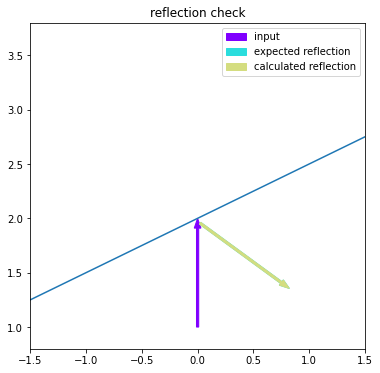

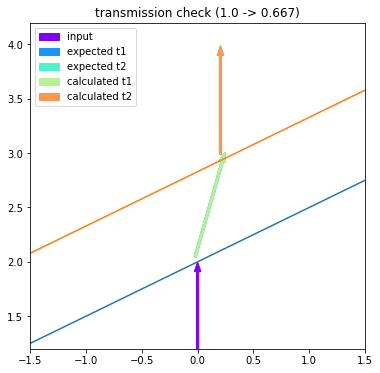

In [110]:
def reflectRay(ray, intersection, epsilon=0.00001):
    ## BEGIN YOUR CODE 1 ##
    # CREATE A NEW RAY REFLECTING ACROSS intersection.normal
    # AND MODIFY origin AND num_bounces ACCORDINGLY
    new_origin = np.float16(intersection.position)
    normal = intersection.normal
    if np.dot(ray.direction, normal)>=0:
        normal = -normal
    new_origin += epsilon * normal
    new_direction = ray.direction - 2 * np.dot(ray.direction, normal) * normal
    new_num_bounces = ray.num_bounces + 1
    ## END YOUR CODE 1 ##
    reflected_ray = Ray(origin=new_origin,
                        direction=new_direction, num_bounces=new_num_bounces)
    return reflected_ray


def computeTransmissionDirection(direction, normal, n_in, n_out):
    ## BEGIN YOUR CODE 2.1 ##
    # DETECT WHETHER total_internal_reflection IS OCURRING.
    # IF SO, RETURN None.
    # OTHERWISE, COMPUTE AND RETURN d_transmit, THE DIRECTION FOR THE REFRACTION RAY.
    total_internal_reflection = False
    if np.dot(normal, direction)>0:
        normal = - normal
    p_1 = direction - np.dot(direction, normal) * normal
    sin_1 = np.linalg.norm(p_1)
    sin_2 = sin_1 * n_out / n_in
    total_internal_reflection = (sin_2>=1)
    if total_internal_reflection:
        return None
    d_transmit = normalize(p_1) * sin_2 - np.sqrt(1 - sin_2**2) * normal
    ## END YOUR CODE 2.1 ##
    return d_transmit


def refractRay(ray, obj, intersection, epsilon=0.00001):
    new_num_bounces = ray.num_bounces+1
    object_index_of_refraction = obj.get_material().ior
    ## BEGIN YOUR CODE 2.2 ##
    # MODIFY THE FOLLOWING VARIABLES AS NECESSARY TO ACCOUNT FOR THE OBJECT'S INDEX OF REFRACTION
    # AND TO OFFSET THE RAY'S new_origin BY A SMALL AMOUNT TO PREVENT SELF-INTERSECTION
    # Note: you will need to handle this differently based on whether
    # intersection.from_inside_object is True or False.
    if intersection.from_inside_object:
        normal = - intersection.normal
        ior_in = 1.0
        ior_out = object_index_of_refraction
    else:
        normal = intersection.normal
        ior_in = object_index_of_refraction
        ior_out = 1.0
    new_origin = intersection.position - epsilon * normal
    ## END YOUR CODE 2.2 ##

    # Calling the helper function you implemented in 2.1.
    # If total internal reflection is occuring, we cast a reflected ray;
    # otherwise we cast a transmitted ray.
    new_direction = computeTransmissionDirection(
        ray.direction, normal, ior_in, ior_out)
    if new_direction is None:
        return reflectRay(ray, intersection)
    transmitted_ray = Ray(
        origin=new_origin, direction=new_direction, num_bounces=new_num_bounces)
    return transmitted_ray


def testReflection():
    ray = Ray(origin=np.array([0, 1, 0]),
              direction=np.array([0, 1, 0]), num_bounces=0)
    intersection = Intersection(position=np.array(
        [0, 2, 0]), normal=normalize(np.array([0.5, -1, 0])))

    reflected_ray = reflectRay(ray, intersection, epsilon=0.05)
    plot_rays([[[-2, 2], [1, 3]]],
              [(ray, "input"), (reference_rays["r"], "expected reflection"),
               (reflected_ray, "calculated reflection")],
              name="reflection check")


def testTransmission():
    ray, obj1, obj2 = load_transmission_test_objects()

    ray_t1 = obj1.get_intersection_t(ray)
    intersection = obj1.get_intersection_info(ray, ray_t1)
    transmitted_ray1 = refractRay(ray, obj1, intersection, epsilon=0.05)

    ray_t2 = obj2.get_intersection_t(transmitted_ray1)
    intersection = obj2.get_intersection_info(transmitted_ray1, ray_t2)
    transmitted_ray2 = refractRay(
        transmitted_ray1, obj2, intersection, epsilon=0.05)
    plot_rays([[[-2, 2], [1, 3]], [[-1.7317, 2.2682928, ], [1.9634144, 3.9634144]]],
              [(ray, "input"),
               (reference_rays["t1"], "expected t1"),
               (reference_rays["t2"], "expected t2"),
               (transmitted_ray1, "calculated t1"),
               (transmitted_ray2, "calculated t2"),
               ],
              ylim=[1.2, 4.2],
              name="transmission check (1.0 -> 0.667)")


testReflection()
testTransmission()

In [128]:
def computeVisibleLight(shadow_ray, objects, light, raytrace_settings) -> Optional[Light]:
    light_dist = np.linalg.norm(light.position-shadow_ray.origin)
    attenuated_color = np.copy(light.color)

    for obj in objects:
        t = obj.get_intersection_t(shadow_ray)
        if t is not None and t < light_dist:
            if not raytrace_settings.enable_shadow_attenuation:
                return None
            material = obj.get_material()
            if material.transmission == 0.0:
                return None
            attenuation_coeffs = material.attenuation_coeffs
            ## BEGIN YOUR CODE 4.2 ##
            # IMPLEMENT SHADOW RAY ATTENUATION. CALCULATE falloff USING BEER'S LAW
            # CHECK HANDOUT PDF IF YOU'RE NOT SURE WHAT TO DO
            falloff = np.exp(- attenuation_coeffs * t)
            ## END YOUR CODE 4.2 ##
            attenuated_color *= material.transmission*falloff
    attenuated_light = Light(position=light.position, color=attenuated_color)
    return attenuated_light


def rayTrace(ray, objects, lights, raytrace_settings):
    eps = raytrace_settings.epsilon
    color = np.zeros(3)
    # Find the closest object
    closest_object = None
    curr_t = np.inf
    for obj in objects:
        t = obj.get_intersection_t(ray)
        if t is not None and t < curr_t:
            curr_t = t
            closest_object = obj
    if closest_object is None:
        return color
    intersection = closest_object.get_intersection_info(ray, curr_t)

    # Cast shadow rays
    visible_lights = []
    for light in lights:
        ## BEGIN YOUR CODE 3.0 ##
        # CREATE THE SHADOW RAY -- YOU SHOULD HAVE DONE THIS IN HW3 ALREADY
        # HINT: MAKE USE OF intersection.position AND raytrace_settings.epsilon HERE
        shadow_ray_origin = intersection.position + \
            eps * intersection.normal  # CHANGE THIS
        shadow_ray_direction = normalize(
            light.position - shadow_ray_origin)  # CHANGE THIS
        shadow_ray = Ray(
            origin=shadow_ray_origin,
            direction=shadow_ray_direction,
        )
        ##END YOUR CODE 3.0 ##
        visible_light = computeVisibleLight(
            shadow_ray, objects, light, raytrace_settings)
        if visible_light is not None:
            visible_lights.append(visible_light)

    # Compute color
    material = closest_object.get_material()
    L_brdf = material.evaluate_brdf(ray, intersection, visible_lights)
    if ray.num_bounces >= raytrace_settings.max_bounces:
        ## DID YOU REMEMBER TO INCREMENT NUM BOUNCES IN reflectRay AND refractRay? ##
        return np.clip(L_brdf, 0, 1)

    c_brdf = 1.0
    if raytrace_settings.enable_reflection and material.reflectivity > 0:
        c_brdf = c_brdf - material.reflectivity
        ## BEGIN YOUR CODE 3.1 ##
        # USE THE reflectRay FUNCTION FROM PART 1 TO CALCULATE reflection_color RECURSIVELY
        reflect_ray = reflectRay(ray, intersection, epsilon=eps)
        reflection_color = rayTrace(reflect_ray, objects, lights, raytrace_settings)
        ## END YOUR CODE 3.1 ##
        color += material.reflectivity*reflection_color

    if raytrace_settings.enable_transmission and material.transmission > 0:
        c_brdf = c_brdf - material.transmission
        ## BEGIN YOUR CODE 3.2 ##
        # USE THE refractRay FUNCTION FROM PART 2.2 TO CALCULATED transmitted_color RECURSIVELY
        refract_ray = refractRay(ray, closest_object, intersection, epsilon=eps)
        transmitted_color = rayTrace(refract_ray, objects, lights, raytrace_settings)
        ## END YOUR CODE 3.2 ##
        color += material.transmission*transmitted_color

    color += L_brdf*c_brdf

    return np.clip(color, 0, 1)


def generateImage(screen_height, screen_width,
                  camera_aperture, film_xlim, film_z,
                  raytrace_settings, objects, lights
                  ):
    aspect_ratio = float(screen_height)/screen_width
    film_ylim = aspect_ratio*film_xlim
    # film plane of pixels (of RGB values) that we compute for our image
    pixel_y = np.linspace(film_ylim[0], film_ylim[1], screen_height)
    pixel_x = np.linspace(film_xlim[0], film_xlim[1], screen_width)
    rendered_image = np.zeros((screen_height, screen_width, 3))

    # loop over each pixel
    for i, y in tqdm(enumerate(pixel_y), total=screen_height):
        for j, x in enumerate(pixel_x):
            pixel_center = np.array([x, y, film_z])
            camera_ray = Ray(origin=pixel_center, direction=normalize(
                pixel_center-camera_aperture))
            rendered_image[screen_height-1-i,
                           j] = rayTrace(camera_ray, objects, lights, raytrace_settings)
    return rendered_image

  0%|          | 0/120 [00:00<?, ?it/s]

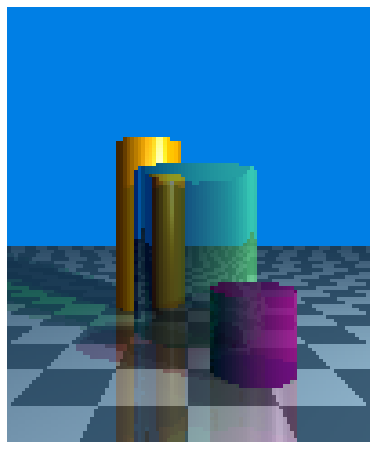

In [131]:
# Load objects and lights
objects = get_default_scene_objects()
lights = get_default_scene_lights()

# Set camera position and film plane
camera_aperture = np.array([0, 0, 1])
film_xlim = np.array([-0.5, 0.5])
film_z = 0

# TODO: change this as you test. This should
raytrace_settings = RayTraceSettings(
    enable_reflection=True, enable_transmission=True, enable_shadow_attenuation=True, epsilon=0.001)
# Set image resolution; feel free to adjust
# (note: starting with a small value is recommended for quick iteration)
screen_height = 120
screen_width = 100
rendered_image = generateImage(screen_height, screen_width,
                               camera_aperture, film_xlim, film_z,
                               raytrace_settings, objects, lights)
show_image(rendered_image, height=8, width=8)

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

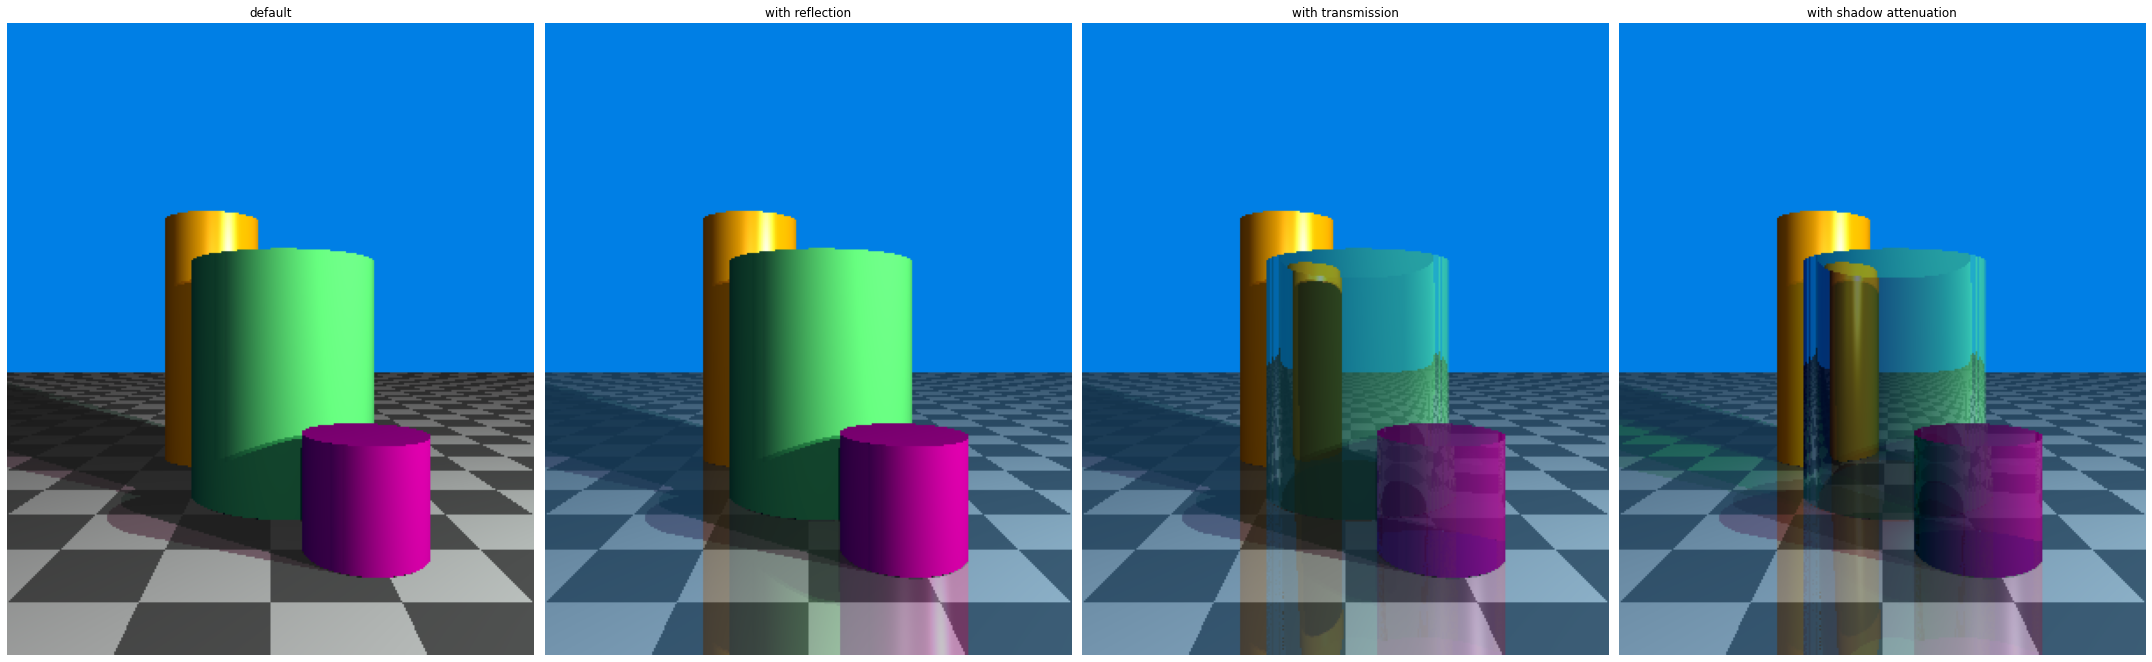

In [132]:
# DO NOT EDIT THIS CELL!!! MAY TAKE 5-10 MINUTES TO RUN ALL 4 IMAGES
screen_height = 360
screen_width = 300
raytrace_settings=RayTraceSettings(enable_reflection=False, enable_transmission=False, enable_shadow_attenuation=False, epsilon=0.001)
rendered_image_1 = generateImage(screen_height, screen_width, 
                               camera_aperture, film_xlim, film_z, 
                               raytrace_settings, objects, lights)
raytrace_settings.enable_reflection=True
rendered_image_2 = generateImage(screen_height, screen_width, 
                               camera_aperture, film_xlim, film_z, 
                               raytrace_settings, objects, lights)
raytrace_settings.enable_transmission=True
rendered_image_3 = generateImage(screen_height, screen_width, 
                               camera_aperture, film_xlim, film_z, 
                               raytrace_settings, objects, lights)
raytrace_settings.enable_shadow_attenuation=True
rendered_image_4 = generateImage(screen_height, screen_width, 
                               camera_aperture, film_xlim, film_z, 
                               raytrace_settings, objects, lights)
plot_images([(rendered_image_1,"default"),
             (rendered_image_2,"with reflection"),
             (rendered_image_3,"with transmission"),
             (rendered_image_4,"with shadow attenuation"),
            ],height=10,width=30)

  0%|          | 0/240 [00:00<?, ?it/s]

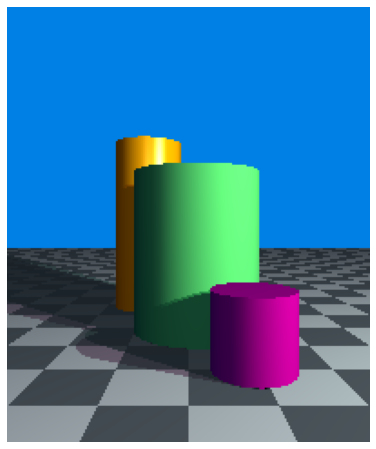

In [134]:
# After you finish
    #TODO 1 reflection (1 pt)
    #TODO 2 refraction (1 pt)
    #TODO 3 recursion for reflection/refraction (1 pt)
    #TODO 4 shadow attenuation (2 pt)
    
# You may try BONUS problems!

# 1 pt: (Easy)
# look at Cylinder and Plane in raytracer_utils,
# extend it to create a sphere object (from last homework)
class Sphere(Geometry):
    def __init__(self, center:np.ndarray, radius:float, material:Material):
        super().__init__(material)
        self.center=center      
        self.radius=radius
    def get_intersection_t(self, ray) -> Optional[float]:
        ### BONUS: FILL THIS OUT
        return None
        ### BONUS: END

    def get_intersection_info(self,ray,t) -> Intersection:
        ### BONUS: FILL THIS OUT
        return Intersection(
            #position=intersect_position,
            #normal=intersect_normal,
            #from_inside_object=from_inside_object
        )
        ### BONUS: END
raytrace_settings=RayTraceSettings(enable_reflection=True, enable_transmission=False, enable_shadow_attenuation=False)
extra_objects = get_default_scene_objects()
extra_objects.append(Sphere(center=np.array([-1,-1.4,-4]),
                            radius=0.6,
                            material=DefaultMaterial(
                                ambient=np.array([0.0,0.2,0.3]),
                                diffuse=np.array([0.0,0.0,0.6]),
                                specular=np.array([0.5,0,0.1]),
                                shininess=20)))
### BONUS: UNCOMMENT TO RENDER
# screen_height = 240
# screen_width = 200
# rendered_image = generateImage(screen_height, screen_width, 
#                               camera_aperture, film_xlim, film_z, 
#                               raytrace_settings,extra_objects, lights)
# show_image(rendered_image, height = 8, width = 8)
### BONUS: UNCOMMENT TO RENDER

    
# 1 pt: (Advanced) 
# create a new generateImageDOF() function that does depth of field via circle of confusion
# see lecture notes and handout. you'll need to generate and trace multiple rays 
# based on random disc sampling of some nonzero aperture size

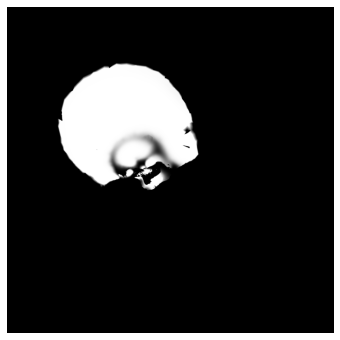

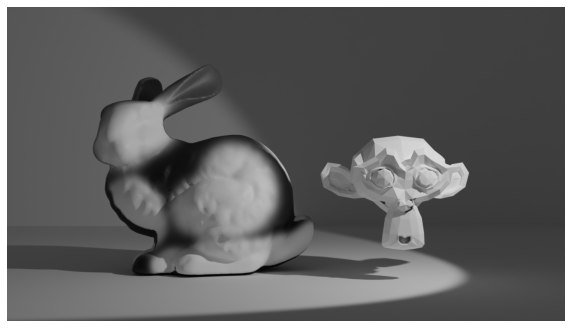

In [140]:
show_image("images/painted_texture.png",height=6,width=6)
show_image("images/painted_texture_render.png",height=6,width=10)

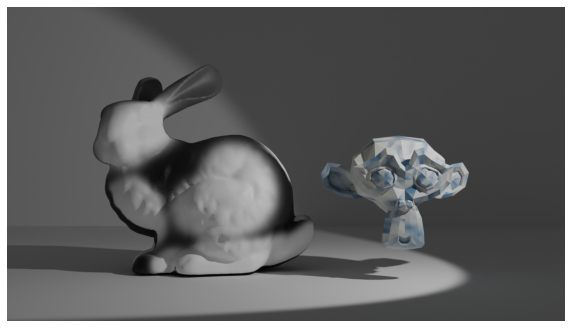

In [139]:
show_image("images/seamless_texture_render.png",height=6,width=10)

In [ ]:
show_image("images/shader_graph.png",height=12,width=12)
show_image("images/shader_graph_render.png",height=6,width=10)

* Describe what you did with the shader graph.
     
     ``` Your answer here```
* If there are any topics you're curious about that we haven't covered in class, list them here.
    
    ```Your answer here```